In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            # 32 x 32
            nn.LeakyReLU(0.2),
            # no batch norm on first layer
            self._block(features_d, features_d*2, 4, 2, 1), # (32x32 -> 16x16)
            self._block(features_d*2, features_d*4, 4, 2, 1), # (16x16 -> 8x8)
            self._block(features_d*4, features_d*8, 4, 2, 1), # (8x8 -> 4x4)
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # (4x4 -> 1x1)
            nn.Sigmoid(),
        )


    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False, # batch norm handles bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4, 1, 0), # (1x1 -> 4x4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # (4x4 -> 8x8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # (8x8 -> 16x16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # (16x16 -> 32x32)
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ), # (32x32 -> 64x64)
            # no batch norm on last layer
            nn.Tanh(), # [-1, 1]
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False, # batch norm handles bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(), # no leaky relu (same as paper)
        )

    def forward(self, x):
        return self.gen(x)

In [4]:
# Initialize weights (taken from DCGAN paper)
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

# testing discriminator and generator
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

In [5]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 2e-4 # from DCGAN paper
batch_size = 128
image_size = 64 # from DCGAN paper
channels_img = 1
z_dim = 100
features_d = 64
features_g = 64
num_epochs = 5

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)]
            # general for any number of channels
        ),
    ]
)

In [6]:
# prepare dataset
dataset = datasets.MNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 57532690.66it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103712066.63it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 63758563.63it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 399340.29it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [7]:
# define networks
gen = Generator(z_dim, channels_img, features_g).to(device)
disc = Discriminator(channels_img, features_d).to(device)

# initialize weights
initialize_weights(gen)
initialize_weights(disc)

# optimizers
opt_gen = optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# set to train mode
gen.train()
disc.train()

# loss function
criterion = nn.BCELoss()

# fixed noise
fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)

# tensorboard writers
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: [0/5] \ LossD: 0.68398726, LossG: 0.78973019


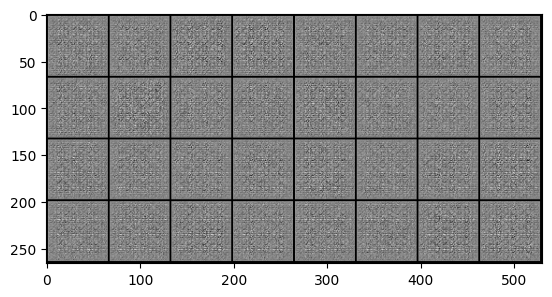

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: [1/5] \ LossD: 0.57230705, LossG: 0.91605592


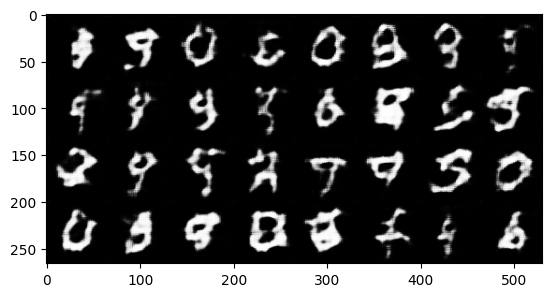

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: [2/5] \ LossD: 0.57488865, LossG: 0.96907687


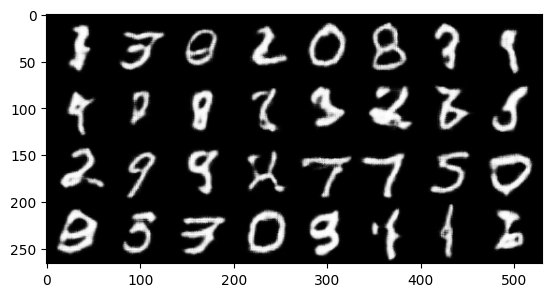

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: [3/5] \ LossD: 0.36342657, LossG: 2.55741334


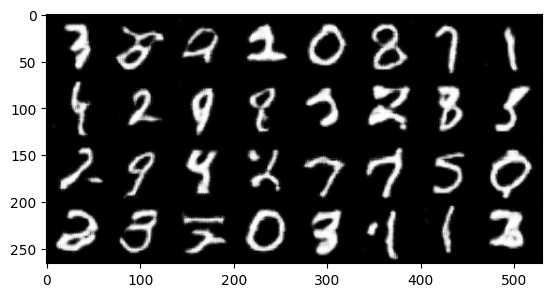

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: [4/5] \ LossD: 0.30228996, LossG: 2.62085819


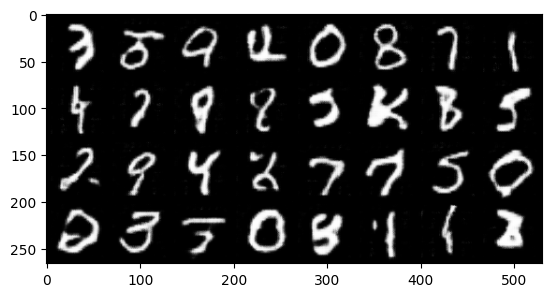

100%|██████████| 469/469 [02:12<00:00,  3.53it/s]


In [8]:

# Training
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(tqdm(loader)):
        real = real.to(device) # real images
        batch_size = real.shape[0]

        # Train Discriminator: max log(D(real)) + log(1 - D(G(z)))
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise) # fake images

        disc_real = disc(real).view(-1) # real images
        lossD_real = criterion(disc_real, torch.ones_like(disc_real)) # Check Md Cell below

        disc_fake = disc(fake).view(-1) # fake images
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake)) # Check Md Cell below

        lossD = (lossD_real + lossD_fake) / 2 # average loss
        # Backpropagation (discriminator)
        disc.zero_grad()
        lossD.backward(retain_graph=True) # retain_graph=True to avoid error when backpropagating to generator
        # Update weights
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output)) # Check Md Cell below
        # Backpropagation (generator)
        gen.zero_grad()
        lossG.backward()
        # Update weights
        opt_gen.step()


        # Print losses occasionally and print to tensorboard
        if batch_idx == 0:
            print(
                f"Epoch: [{epoch}/{num_epochs}] \ "
                f"LossD: {lossD:.8f}, LossG: {lossG:.8f}"
            )
            with torch.no_grad():
                fake = gen(fixed_noise)
                data = real

                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                # write to tensorboard
                # writer fake images
                writer_fake.add_image(
                    "Fake Images", img_grid_fake, global_step=step
                )
                # writer real images
                writer_real.add_image(
                    "Real Images", img_grid_real, global_step=step
                )
                step += 1

                plt.imshow(img_grid_fake.to("cpu").permute(1, 2, 0))
                plt.show()


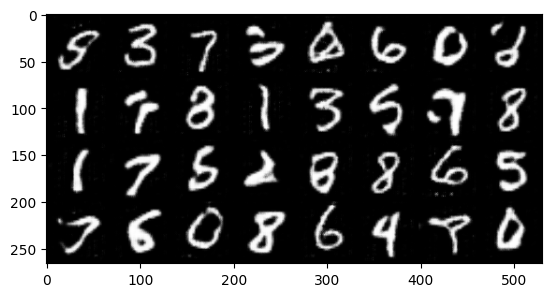

In [28]:
out = gen(torch.randn(32, z_dim, 1, 1).to(device)).to("cpu").detach()
plt.imshow(torchvision.utils.make_grid(out, normalize=True).permute(1,2,0))